# Retention By Activation Month

#### From fonoma-prod project in BigQuery
```MySQL
select
    -- Acquisition month in YYYYMM date format (cohort)
    replace(left(date(person.first_recharge_on),7),'-','') as cohort,
    -- Months since acquisition
    month(recharge.completed_on) - month(person.first_recharge_on)
        + (year(recharge.completed_on) - year(person.first_recharge_on))*12 as months,
    -- Months in YYYYMM format
    replace(left(date(recharge.completed_on),7),'-','') as yyyymm,
    -- Users in cohort who still are active
    count(distinct recharge.who.id) as actives
from [fonoma.Person] as person
join each [fonoma.Recharge] as recharge on person.__key__.id = recharge.who.id
where
    -- query completed recharges only
    recharge.status = 25 
and
    -- query only people who became users 12 months ago
    left(date(person.first_recharge_on),7) = 
   left(date(date_add(current_date(),-1,'year')),7)
group by 1,2,3
```

In [5]:
import pandas as pd
from pandas.io import gbq # to communicate with Google BigQuery

project_id = 'fonoma-prod'
query_code = """
select
    replace(left(date(person.first_recharge_on),7),'-','') as cohort,
    month(recharge.completed_on) - month(person.first_recharge_on)
        + (year(recharge.completed_on) - year(person.first_recharge_on))*12 as months,
    replace(left(date(recharge.completed_on),7),'-','') as yyyymm,
    count(distinct recharge.who.id) as actives
from [fonoma.Person] as person
join each [fonoma.Recharge] as recharge on person.__key__.id = recharge.who.id
where
    recharge.status = 25 
and
    left(date(person.first_recharge_on),7) = 
   left(date(date_add(current_date(),-1,'year')),7)
group by 1,2,3
order by 1,2,3
"""

try:
    data = gbq.read_gbq(query_code, project_id=project_id)
except:
    print 'Error reading the dataset'

Requesting query... ok.
Job ID: job_BSsyGfbSh1BLNvub04BJPtK3j-D-
Query running...
Query done.
Processed: 17.7 MB
Standard price: $0.00 USD

Retrieving results...
Got 12 rows.

Total time taken 2.15 s.
Finished at 2017-09-28 19:16:43.


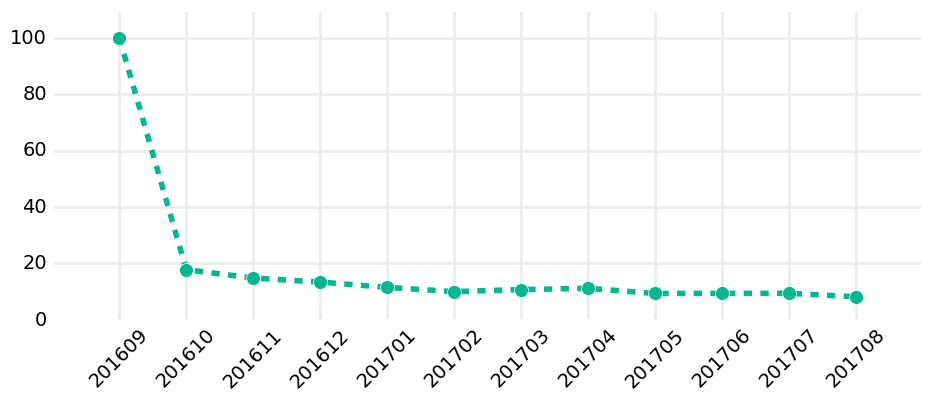

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

d = data[data['cohort']=='201609']
fig, ax = plt.subplots(1, sharex=False, sharey=False,figsize=plt.figaspect(.4))
plt.style.use('quinientostreintayocho')
fig = plt.plot(d['months'],100 * d['actives']/d['actives'][0],'--o',markersize=10,markeredgecolor='#ffffff')
fig = plt.xticks(d['months'],d['yyyymm'],rotation=45)
fig = plt.grid(which='major',color='#ececec',linestyle='-',linewidth=2,axis='both')
fig = plt.axis([-1,len(data['yyyymm']),0,110])